In [1]:
from pathinit import *

import numpy as np

import jax
import jax.numpy as jnp
import jaxopt
jax.config.update("jax_enable_x64", True)

import matplotlib as mpl
from matplotlib import pyplot as plt

import corner
import arviz as az
mpl.rcParams['font.size'] = 20

In [2]:
def mean_fn(x, params):
    """Parametrisation avant et apres RT (t=0) """
    R0 = params["R0"]
    v  = params["v"]
    k  = params["k"]
    tau =  params["tau"]
    return jnp.piecewise(
        x, [x < 0, x >= 0],
        [lambda x: R0 + v*x, 
         lambda x: R0 + v*x - k*(1.-jnp.exp(-x/tau))
        ])

In [3]:
rng_key = jax.random.PRNGKey(42)
rng_key, rng_key0, rng_key1, rng_key2 = jax.random.split(rng_key, 4)

In [4]:
rng_key, rng_key0, rng_key1, rng_key2

(DeviceArray([2954079971, 2575172198], dtype=uint32),
 DeviceArray([1139032965, 1035738655], dtype=uint32),
 DeviceArray([3276725750, 1223413151], dtype=uint32),
 DeviceArray([173471767,  13772463], dtype=uint32))

In [5]:
tMes = jax.random.uniform(rng_key0,minval=-5.,maxval=5.0,shape=(20,))
tMes=jnp.append(tMes,0.0)
tMes=jnp.sort(tMes)

In [6]:
tMes

DeviceArray([-4.58129224, -3.67409497, -3.04910426, -2.79693803,
             -1.99901629, -1.47170537, -1.43355488, -0.49473482,
              0.        ,  0.33433767,  0.41544769,  0.79927304,
              0.8931146 ,  1.32025748,  2.28478418,  2.64711365,
              2.90659961,  3.21894342,  3.48934373,  3.71929718,
              4.53745297], dtype=float64)

In [7]:
par_true={"R0":35.0, "v":2.20, "k":15.5, "tau": 1.0}
sigma_obs=1.0

In [8]:
RMes = mean_fn(tMes,par_true) + sigma_obs * jax.random.normal(rng_key1,shape=tMes.shape)

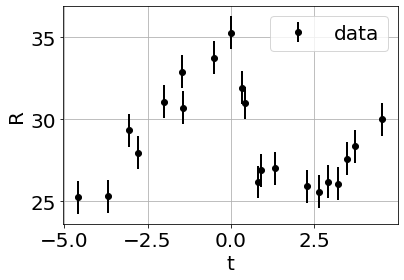

In [9]:
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

In [10]:
def lik(p,t,R, sigma_obs=1.0):
    params = {"R0":p[0], "v":p[1], "k":p[2], "tau": p[3]}
    resid = mean_fn(t, params)-R
    return 0.5*jnp.sum((resid/sigma_obs) ** 2) 

In [11]:
def get_infos(res, model, t,R):
    params = res.params
    fun_min= res.state.fun_val
    jacob_min=jax.jacfwd(model)(params, t,R)
    inv_hessian_min=jax.scipy.linalg.inv(jax.hessian(model)(params, t,R))
    return params,fun_min,jacob_min,inv_hessian_min

In [12]:
minimizer = jaxopt.ScipyMinimize(fun=lik,method='BFGS',options={'gtol': 1e-6,'disp': False})
init_params = jnp.array([18.,1.,10.,1.])
res1 = minimizer.run(init_params, t=tMes, R=RMes)
params,fun_min,jacob_min,inv_hessian_min = get_infos(res1, lik, t=tMes,R=RMes)
print("params:",params,"\nfun@min:",fun_min,"\njacob@min:",jacob_min,
     "\n invH@min:",inv_hessian_min)

params: [35.35772761  2.37101534 16.57772394  0.93055088] 
fun@min: 6.710174806788165 
jacob@min: [-4.49239437e-08 -2.15599616e-08  2.22663577e-08 -9.25418597e-08] 
 invH@min: [[ 0.30761634  0.09638602  0.63829182 -0.00407356]
 [ 0.09638602  0.04649244  0.26419768  0.00268039]
 [ 0.63829182  0.26419768  1.84093013  0.04456978]
 [-0.00407356  0.00268039  0.04456978  0.0111473 ]]


In [13]:
def plot_landscape(ax,model,xdata,ydata, par_min, idx=(0,1), bounds=(0.,1.,0.,1.), model_args=(), model_kwargs={}):
    xmin,xmax,ymin,ymax = bounds
    grid = x0,y0 = np.mgrid[xmin:xmax:101j,ymin:ymax:101j]

    pts = np.swapaxes(grid,0,-1).reshape(-1,2)
    points = np.repeat(par_min[None, :], pts.shape[0], axis=0)
    for i in (0,1):
        points = points.at[:,idx[i]].set(pts[:,i])
    
    v = jax.vmap(lambda p,x,y: model(p,x,y,*model_args, **model_kwargs), in_axes = (0,None,None))(points,xdata,ydata)
    v = np.swapaxes(v.reshape(101,101),0,-1)
    g0=ax.contourf(x0,y0,v, levels = 100)
    ax.contour(x0,y0,v, levels = 50, colors = 'w')

    grid = np.mgrid[xmin:xmax:10j,ymin:ymax:10j]
    pts = np.swapaxes(grid,0,-1).reshape(-1,2)
    points = np.repeat(par_min[None, :], pts.shape[0], axis=0)
    for i in (0,1):
        points = points.at[:,idx[i]].set(pts[:,i])

    gradients = jax.vmap(
        jax.grad(
            lambda p,x,y: model(p,x,y, *model_args, **model_kwargs)
        ), in_axes = (0,None,None)
    )(points,xdata,ydata)

    scale = int(0.2*np.max(gradients))
    ax.quiver(
        points[:,idx[0]],
        points[:,idx[1]],
        gradients[:,idx[0]],
        gradients[:,idx[1]],
        color="white",
        angles = 'xy',
        scale_units='xy',
        scale = scale
    )
    ax.set_aspect("equal")
    fig.colorbar(g0,ax=ax,shrink=0.5)

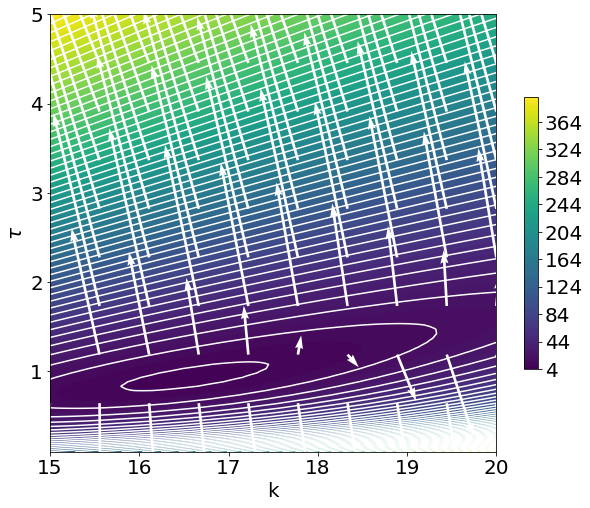

In [14]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_landscape(ax,model=lik,xdata=tMes,ydata=RMes,par_min=params, idx=(2,3),bounds=(15,20.,0.1,5.))
plt.xlabel("k")
plt.ylabel(r"$\tau$")
plt.show()

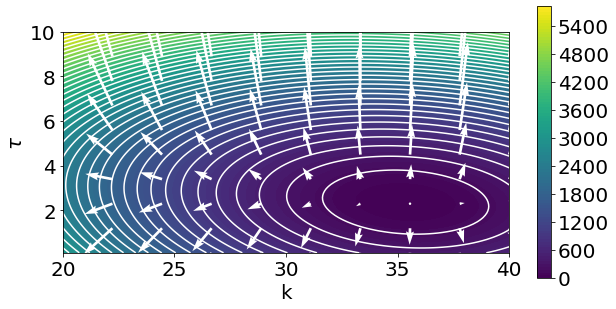

In [15]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_landscape(ax,model=lik,xdata=tMes,ydata=RMes,par_min=params, idx=(0,1),bounds=(20,40.,0.1,10.))
plt.xlabel("k")
plt.ylabel(r"$\tau$")
plt.show()

In [16]:
t_val = np.linspace(-5,5,100)

In [17]:
Rtrue_val = mean_fn(t_val,par_true)

In [18]:
param_spls = jax.random.multivariate_normal(rng_key2,mean=params,cov=inv_hessian_min,shape=(1000,))

2022-04-12 16:43:43.205013: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:212] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.3 = f64[1000,4]{1,0} custom-call(f64[1000,4]{1,0} %multiply.313, f64[4,4]{0,1} %select.49, f64[1000,4]{1,0} %broadcast.322), custom_call_target="__cublas$gemm", metadata={op_name="jit(_multivariate_normal)/jit(main)/add" source_file="/tmp/ipykernel_174/1623606051.py" source_line=1}, backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":1,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"1\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]},\"batch_size\":\"1\",\"lhs_stride\":\"4000\",\"rhs_stride\":\"16\"}" failed. Falling back to default algorithm.  Per-algorithm errors:


In [19]:
func = jax.vmap(lambda x: mean_fn(t_val,{"R0":x[0],"v":x[1],"k":x[2],"tau":x[3]}))

In [20]:
Rall_val= func(param_spls)

In [21]:
Rmean_val = jnp.mean(Rall_val,axis=0)

In [22]:
std_R_val = jnp.std(Rall_val,axis=0)

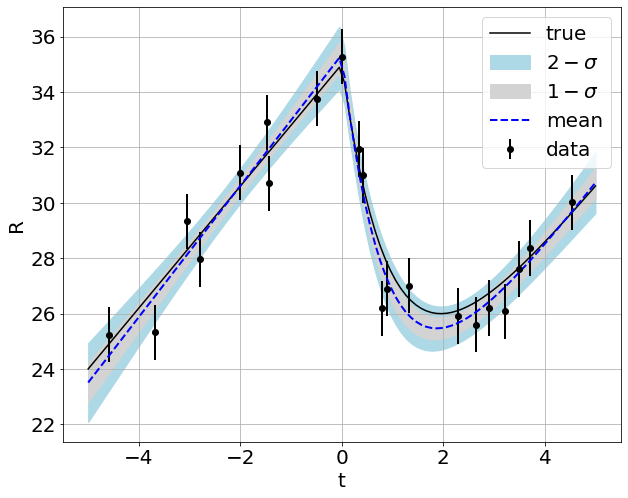

In [23]:
fig=plt.figure(figsize=(10,8))
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.plot(t_val,Rtrue_val,c='k',label="true")

plt.fill_between(t_val, Rmean_val-2*std_R_val, Rmean_val+2*std_R_val, 
                    color="lightblue",label=r"$2-\sigma$")
plt.fill_between(t_val, Rmean_val-std_R_val, Rmean_val+std_R_val, 
                    color="lightgray",label=r"$1-\sigma$")
# plot mean prediction
plt.plot(t_val, Rmean_val, "blue", ls="--", lw=2.0, label="mean")


plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();